# Implementación del método de Newton para la optimización de tratamientos de radioterapia de intensidad modulada (IMRT)
## Minimax
#### Andrés Camilo Sevilla Moreno
19 de marzo de 2021


In [1]:
# Import sparse module from SciPy package 
from scipy import sparse
# Import csr_matrix function from SciPy package
from scipy.sparse import csr_matrix
#Import inv operation from from SciPy package
from scipy.sparse.linalg import inv
# Import NumPy module
import numpy as np
# Import MatPlotLib module
import matplotlib as mpl
# Import PyPlot function from NumPy
import matplotlib.pyplot as plt
# Import Image function from PIL
from PIL import Image

In [40]:
def getStructureFromName(structureName):
    for i in range(np.size(structures,0)):
        if(structureName==structures[i][3]):
            return structures[i]
        
def getObjetivesFromStructure(structure):
    objetivesFromStructure=[]
    for i in range(np.size(objetives,0)):
        if(structure[0]==objetives[i][0]):
            objetivesFromStructure.append(objetives[i])
    return objetivesFromStructure

def getStructureFromObjetive(objetive):
    for i in range(np.size(structures,0)):
        if(objetive[0]==structures[i][0]):
            return structures[i]

# Define PTV dose deviation function for x intensity vector
def dObjetives(x,scenario):
    dObjetives = []
    for i in range(np.size(objetives,0)):
        structureIndex=getStructureFromObjetive(objetives[i])[0]
        if(objetives[i][1]=="squared_deviation"):
            dObjetives.append(T[structureIndex]*(Dij[scenario]*x-objetives[i][2]))
        if(objetives[i][1]=="squared_overdosing"):
            dObjetives.append(T[structureIndex]*(Dij[scenario]*x-objetives[i][2])*(Dij[scenario]*x>objetives[i][2]))
        if(objetives[i][1]=="squared_underdosing"):
            dObjetives.append(T[structureIndex]*(Dij[scenario]*x-objetives[i][2])*(Dij[scenario]*x<objetives[i][2]))
    return dObjetives

# Define objective function
def F(x,scenario):
    F = 0
    for i in range(np.size(objetives,0)):
        F+=objetives[i][3]*pow(dObjetives(x,scenario)[i],2).sum()
    return F/nVoxels

# Define objective function
def F_robust(x):
    WCF = 0
    WCScen = -1
    for i in range(np.size(scenarios,0)):
        if(F(x,i)>=WCF):
            WCF=F(x,i)
            WCScen=i
    return WCF, WCScen

In [3]:
def NablaF(x,scenario):
    NablaF = 0
    for i in range(np.size(objetives,0)):
        structureIndex=getStructureFromObjetive(objetives[i])[0]
        NablaF+=objetives[i][3]*Dij[scenario].transpose()*T[structureIndex]*dObjetives(x,scenario)[i]
    return NablaF

def Nabla2F(x,scenario):
    Nabla2F = 0
    for i in range(np.size(objetives,0)):
        structureIndex=getStructureFromObjetive(objetives[i])[0]
        Nabla2F+=objetives[i][3]*Dij[scenario].transpose()*T[structureIndex]*Dij[scenario]
    return Nabla2F

def Nabla2_invF(x,scenario):
    return csr_matrix(inv(Nabla2F(x,scenario)))

def new_x(x,scenario):
    tmp_x=x-(1/N)*Nabla2_invF(x,scenario)*NablaF(x,scenario)
    return tmp_x*(tmp_x>0)

In [4]:
def normFluence(x,scenario):
    norm = 1
    for i in range(np.size(objetives,0)):
        structureIndex=getStructureFromObjetive(objetives[i])[0]
        if(objetives[i][1]=="squared_deviation" and structures[structureIndex][1]=="TARGET"):
            Dose=T[structureIndex]*(Dij[scenario]*x)
            amplitudes, bins = np.histogram(Dose[Dose>0], bins=np.linspace(0, 40,200))
            amplitudes=100*amplitudes/amplitudes.sum()
            cumulatives=np.cumsum(amplitudes)
            norm=objetives[i][2]/bins[np.where(cumulatives>=5)[0][0]]
            break
    return x*norm

In [5]:
def plot3DMap(anArray,title,unit,maxValue):
    
    anArray=np.array(anArray).reshape((dimVoxels[0], dimVoxels[1], dimVoxels[2]), order='F') 
    fig=plt.figure(figsize=(16,3))
    fig.suptitle(title, fontsize=16)
    
    ax1=fig.add_subplot(131)
    ax1.set_xlabel('X [cm]', fontsize=13,labelpad=15)
    ax1.set_ylabel('Y [cm]', fontsize=13,labelpad=15)
    pl=ax1.imshow(anArray[:,:,10],vmin=0, vmax=maxValue)
    plt.colorbar(pl).set_label(unit)

    ax2=fig.add_subplot(132)
    ax2.set_xlabel('X [cm]', fontsize=13,labelpad=15)
    ax2.set_ylabel('Y [cm]', fontsize=13,labelpad=15)
    pl=ax2.imshow(anArray[25,:,:],vmin=0, vmax=maxValue)
    plt.colorbar(pl).set_label(unit)

    ax3=fig.add_subplot(133)
    ax3.set_xlabel('X [cm]', fontsize=13,labelpad=15)
    ax3.set_ylabel('Y [cm]', fontsize=13,labelpad=15)
    pl=ax3.imshow(anArray[:,25,:],vmin=0, vmax=maxValue)
    plt.colorbar(pl).set_label(unit)
    
def plotFluenceMap(x):
    
    x=x.reshape(nBixels)

    fig=plt.figure(figsize=(16,10))

    minBixel = 0
    maxBixel = 0
    i=0
    for n in np.cumsum(dimBixels):
        maxBixel=n-1
        i+=1
        beam=np.zeros((10,10))
        beam[beam_x[minBixel:maxBixel],beam_y[minBixel:maxBixel]]=x[minBixel:maxBixel]
        ax=fig.add_subplot(5,5,i)
        #ax.set_xlabel('X [cm]', fontsize=13,labelpad=15)
        #ax.set_ylabel('Y [cm]', fontsize=13,labelpad=15)
        pl=ax.imshow(beam,origin="lower",extent=[-20,20,-20,20],vmin=0)
        plt.colorbar(pl)
        minBixel=maxBixel+1

def plotDVH(x,scenariosArray,structureNamesArray):
    fig=plt.figure(figsize=(14,5))
    fig.add_subplot(111)

    plt.xlabel("Dose [Gy]", fontsize=13)
    plt.xticks(fontsize=13)
    plt.ylabel("Relative counts [%]", fontsize=13)
    plt.xticks(fontsize=13)

    for scenario in scenariosArray:
        for anStructureName in structureNamesArray:
            structure=getStructureFromName(anStructureName)
            i=structure[0]
            Dose=T[i]*(Dij[scenario]*x)
            amplitudes, bins = np.histogram(Dose[Dose>0], bins=np.linspace(0, 40,200))
            amplitudes=100*amplitudes/amplitudes.sum()
            plt.hist(bins[:-1], bins=bins, weights=amplitudes, density=False, histtype='step', cumulative=-1, color=structures[i][4])
            #plt.hist(bins[:-1], bins=bins, weights=amplitudes, density=False, histtype='step', cumulative=-1,label=structures[i][3],color=structures[i][4])
           
    for anStructureName in structureNamesArray:
        structure=getStructureFromName(anStructureName)  
        for objetive in getObjetivesFromStructure(structure):
            if(objetive[1]=="squared_overdosing"):
                plt.axvline(objetive[2], 0, 1, linestyle='dashed',linewidth=1)
                #plt.axvline(objetive[2], 0, 1, label='D_max='+str(objetive[2])+"Gy",color=structures[objetive[0]][4],linestyle='dashed',linewidth=1)
            if(objetive[1]=="squared_underdosing"):
                plt.axvline(objetive[2], 0, 1, linestyle='dashed',linewidth=1)
                #plt.axvline(objetive[2], 0, 1, label='D_min='+str(objetive[2])+"Gy",color=structures[objetive[0]][4],linestyle='dashed',linewidth=1)
            if(objetive[1]=="squared_deviation" and structures[objetive[0]][1]=="TARGET"):
                plt.scatter(objetive[2], 95, s=10,color=structures[objetive[0]][4])
                #plt.scatter(objetive[2], 95, s=10,label='V95=100',color=structures[objetive[0]][4])

    handles = []
    for anStructureName in structureNamesArray:
        structure=getStructureFromName(anStructureName)
        i=structure[0]
        handles.append(mpl.lines.Line2D([], [], color=structures[i][4], label=structures[i][3]))
                
    plt.legend(handles=handles,loc='right')
    plt.legend(handles=handles,loc='right')
    plt.show()

In [6]:
sigma=5 # [mm]
def gaussian(x):
    return np.exp(-np.power(x, 2.) / (2 * np.power(sigma, 2.)))

In [7]:
# Define Dij parameters

# Number of voxels
dimVoxels=np.array([50,50,41])
nVoxels=dimVoxels[0]*dimVoxels[1]*dimVoxels[2]
#print(nVoxels)

# Number of bixels
dimBixels=np.array([45,59,50,58,55,55,58,48,59])
nBixels=dimBixels.sum()
#print(nBixels)

# Number of fields
N=dimBixels.size
#print(N)

In [8]:
scenarios = []
#scenarios.append([index,"Dij_filename",shifted isocenter, shifting amplitude, weight])
scenarios.append([0,"000.txt","(0,0,0)",0,1])
scenarios.append([1,"-500.txt","(-5,0,0)",-5,1])
scenarios.append([2,"500.txt","(5,0,0)",5,1])
scenarios.append([3,"0-50.txt","(0,-5,0)",-5,1])
scenarios.append([4,"050.txt","(0,5,0)",5,1])
scenarios.append([5,"00-5.txt","(0,0,-5)",-5,1])
scenarios.append([6,"005.txt","(0,0,5)",5,1])

In [9]:
Dij = []
for anScenario in scenarios:
    i,j,D=np.loadtxt(anScenario[1],delimiter="\t",usecols =(0, 1, 2),unpack=True)
    i=i-1
    j=j-1
    # create sparse matrix for Dij
    Dij.append(sparse.csr_matrix((D, (i, j)), shape=(nVoxels, nBixels)))
    
#Dij[0]=Dij[0].todense()
#print(Dij[0].shape)

Calculate weight for each scenario according to gaussian distribution

In [10]:
cumulative_weight=0
for anScenario in scenarios:
    anScenario[4]=gaussian(anScenario[3])
    cumulative_weight+=anScenario[4]

Normalized weight or scenario probability

In [11]:
for anScenario in scenarios:
    anScenario[4]/=cumulative_weight

Calculate cumulative weight or scenario probability

In [12]:
cumulative_weight=0
for anScenario in scenarios:
    cumulative_weight+=anScenario[4]
print(cumulative_weight)

1.0


In [13]:
# Load bixels position array for all beams
beam_x,beam_y=np.loadtxt("beam_pos.txt",delimiter="\t",skiprows=0,usecols =(0, 1),unpack=True)
#print(beam_x,beam_y)
beam_x+=40
beam_y+=40
beam_x/=10
beam_y/=10

beam_x=beam_x.astype(int)
beam_y=beam_y.astype(int)

In [14]:
## Load OAR info
structures = []
structures.append([0,"TARGET",np.loadtxt("iPTV.txt"),"PTV", "red"])
structures.append([1,"TARGET",np.loadtxt("iCTV.txt"),"CTV", "orange"])
structures.append([2,"OAR",np.loadtxt("iBody.txt"),"Body","green"])
structures.append([3,"OAR",np.loadtxt("iRectum.txt"),"Rectum","blue"])
structures.append([4,"OAR",np.loadtxt("iBladder.txt"),"Bladder","pink"])
structures.append([5,"OAR",np.loadtxt("iLeftFemoralHead.txt"),"Left Femoral Head","cyan"])
structures.append([6,"OAR",np.loadtxt("iRightFemoralHead.txt"),"Right Femoral Head","cyan"])

# create sparse matrix for OAR (OAR operator)
T = []
for anStructure in structures:
    T.append(sparse.csr_matrix((1*(anStructure[2]>0), (anStructure[2], anStructure[2])), shape=(nVoxels, nVoxels)))

T[2]=T[2]-T[0]
#print(np.shape(OAR))

In [15]:
# Setting PTV objetives and dose prescription
objetives = []
objetives.append([1,"squared_underdosing",28.5,500])
objetives.append([1,"squared_overdosing",31.5,500])
objetives.append([1,"squared_deviation",30,500])
objetives.append([2,"squared_overdosing",25,140])
objetives.append([3,"squared_overdosing",20,80])
objetives.append([4,"squared_overdosing",20,80])
objetives.append([5,"squared_overdosing",10,80])
objetives.append([6,"squared_overdosing",10,80])

In [34]:
# Initialize intensity vector 
x_robust=np.ones(nBixels).reshape(nBixels,1)
#print(x_robust.shape)

In [35]:
x_robust=normFluence(x_robust,0)

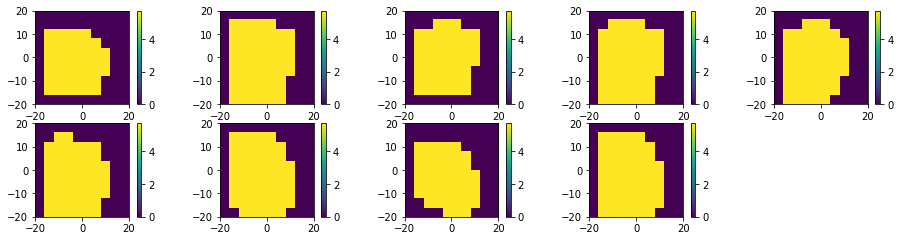

In [36]:
# Plot initial intensity values per bixel and beam
plotFluenceMap(x_robust)

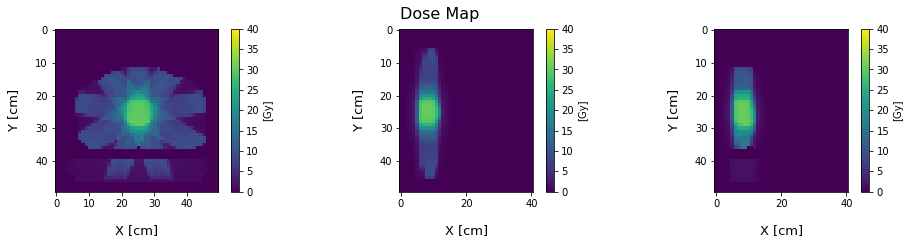

In [37]:
d=Dij[0]*x_robust
plot3DMap(d,"Dose Map","[Gy]",40)

In [41]:
print(F_robust(x_robust))

(9.400270403162038, 6)


In [44]:
%%time
F_results=[]
Scen_results=[]
# Define gradient of x intensity
for i in range(100):
    WCF = F_robust(x_robust)[0]
    WCScen = F_robust(x_robust)[1]
    F_results.append(WCF)
    Scen_results.append(WCScen)
    x_robust=new_x(x_robust,WCScen)
    print(i,F_results[i],Scen_results[i])

0 7.927204898164969 6
1 7.3043065430459855 6
2 6.7455024178995 6
3 6.243537295906809 6
4 5.7920633143144125 6
5 5.3854770475564955 6
6 5.1157033264308795 5
7 4.802677011047525 6
8 4.614879634829859 5
9 4.349213792258774 4
10 4.221649549013775 5
11 3.9609859112662247 6
12 3.8787102175119306 5
13 3.6546890405677117 6
14 3.593742984747458 5
15 3.404887283456553 6
16 3.355672658573423 5
17 3.1987531701201015 6
18 3.154892363677832 5
19 3.0263784143856447 6
20 2.9834557212011026 5
21 2.8803851528231355 6
22 2.835545999498441 5
23 2.7548105369047353 6
24 2.70678183117176 5
25 2.6454197328263955 6
26 2.59376100838485 5
27 2.549303327149209 6
28 2.49386295451653 5
29 2.4639938368894883 6
30 2.4049033087836627 5
31 2.387531021067675 6
32 2.325054696465726 5
33 2.3184352625386766 6
34 2.252881869470894 5
35 2.2555848521586075 6
36 2.187275663094421 5
37 2.1981109702643944 6
38 2.1348587230170204 4
39 2.193768767494808 5
40 2.089257251871065 6
41 2.131869950899448 5
42 2.0449363284572204 6
43 2.0

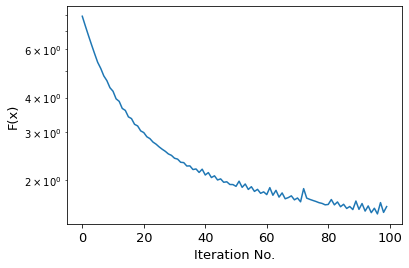

In [45]:
plt.xlabel("Iteration No.", fontsize=13)
plt.xticks(fontsize=13)
plt.ylabel("F(x)", fontsize=13)
plt.xticks(fontsize=13)
plt.plot(F_results)
plt.yscale("log")
plt.show()

/usr/local/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) 

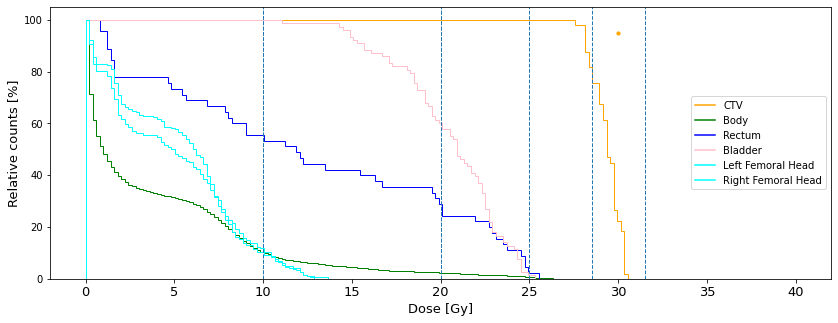

In [46]:
#x_robust=normFluence(x_robust,0)
plotDVH(x_robust,[0],["CTV","Body","Rectum","Bladder","Left Femoral Head","Right Femoral Head"])

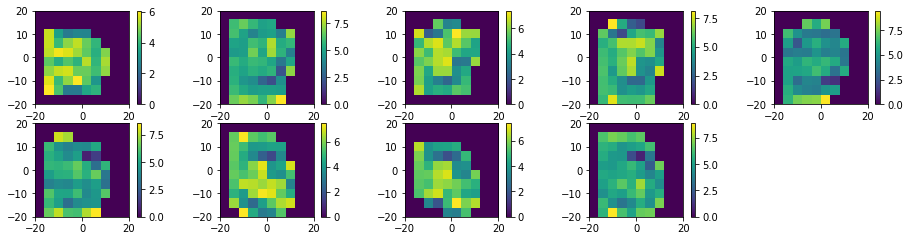

In [47]:
# Plot initial intensity values per bixel and beam
plotFluenceMap(x_robust)

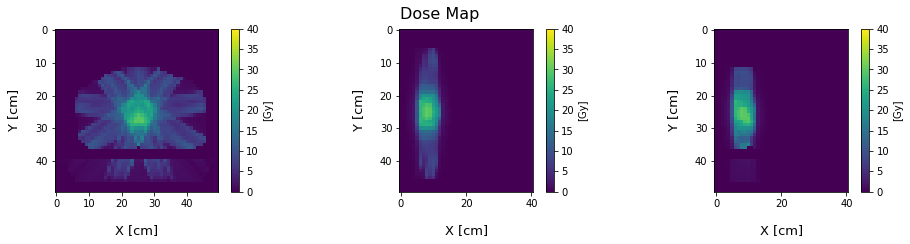

In [48]:
d=Dij[0]*x_robust
plot3DMap(d,"Dose Map","[Gy]",40)

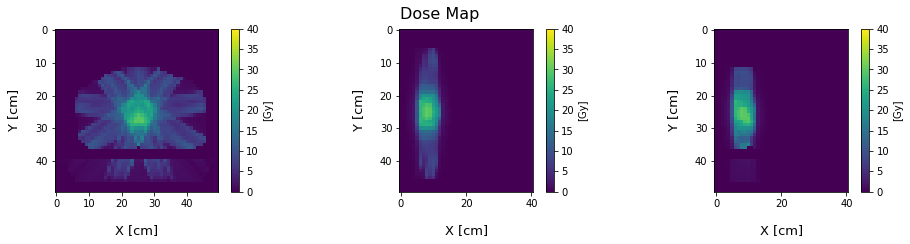

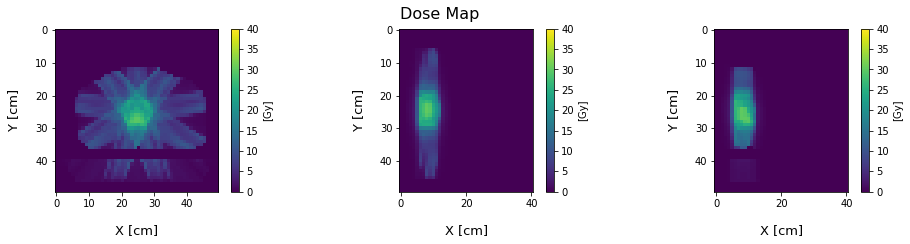

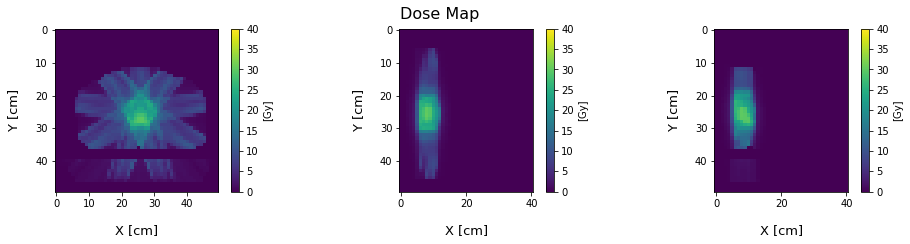

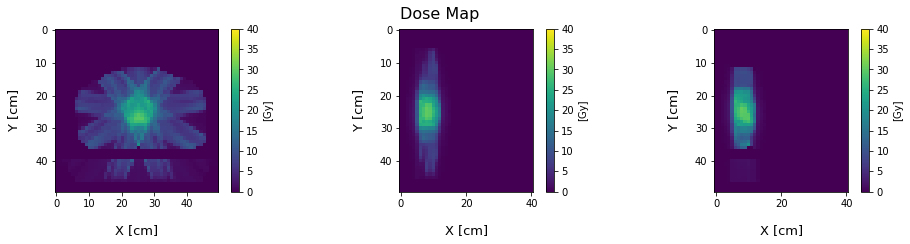

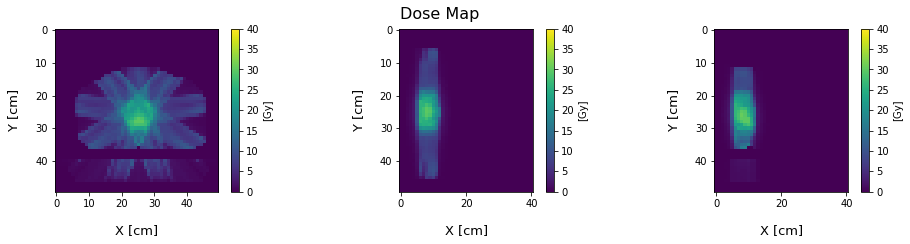

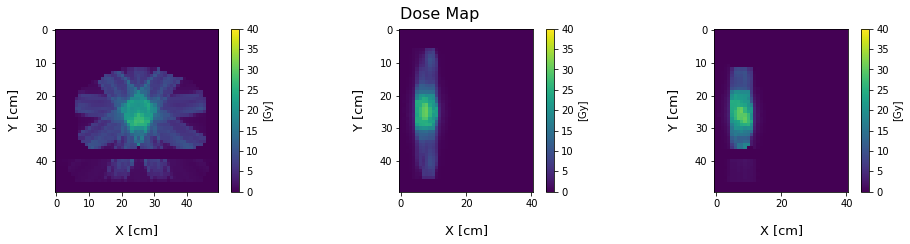

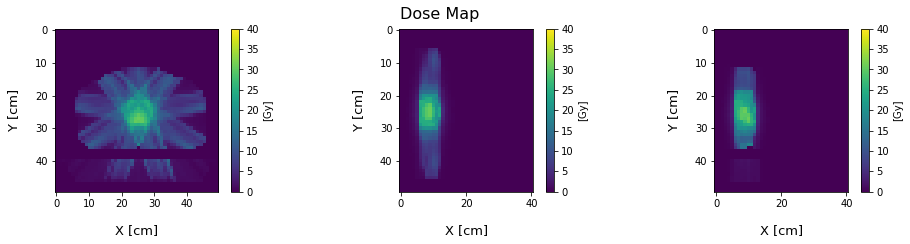

In [49]:
for i in range(np.size(scenarios,0)):
    d=Dij[i]*x_robust
    plot3DMap(d,"Dose Map","[Gy]",40)

/usr/local/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) 

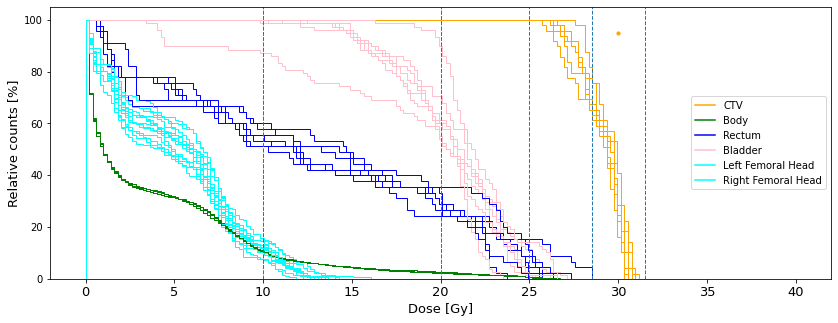

In [50]:
#x=normFluence(x,0)
plotDVH(x_robust,[0,1,2,3,4,5,6],["CTV","Body","Rectum","Bladder","Left Femoral Head","Right Femoral Head"])

In [51]:
d_mean_robust=np.zeros(nVoxels)
d_mean_robust=(Dij[0]*x_robust+Dij[1]*x_robust+Dij[2]*x_robust+Dij[3]*x_robust+Dij[4]*x_robust+Dij[5]*x_robust+Dij[6]*x_robust)/7

In [52]:
d_error_robust=np.zeros(nVoxels)
d_error_robust=pow(Dij[0]*x_robust-d_mean_robust,2)+pow(Dij[1]*x_robust-d_mean_robust,2)+pow(Dij[2]*x_robust-d_mean_robust,2)+pow(Dij[3]*x_robust-d_mean_robust,2)+pow(Dij[4]*x_robust-d_mean_robust,2)+pow(Dij[5]*x_robust-d_mean_robust,2)+pow(Dij[6]*x_robust-d_mean_robust,2)

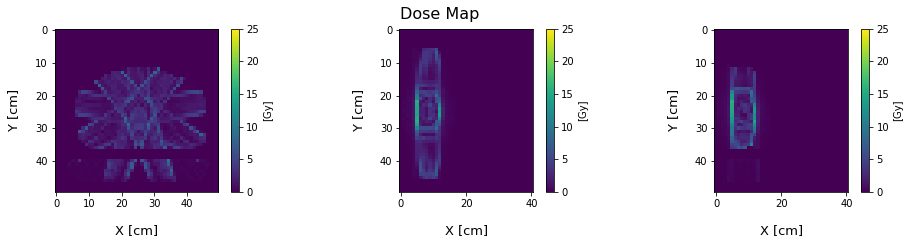

In [53]:
plot3DMap(pow(d_error_robust,0.5),"Dose Map","[Gy]",25)

In [54]:
print(pow(d_error_robust,0.5).max())

16.106364984333574


In [55]:
d_mean_robust=np.zeros(nVoxels)
d_mean_robust=(T[1]*Dij[0]*x_robust+T[1]*Dij[1]*x_robust+T[1]*Dij[2]*x_robust+T[1]*Dij[3]*x_robust+T[1]*Dij[4]*x_robust+T[1]*Dij[5]*x_robust+T[1]*Dij[6]*x_robust)/7

In [56]:
d_error_robust=np.zeros(nVoxels)
d_error_robust=(pow(T[1]*(Dij[0]*x_robust-d_mean_robust),2)+pow(T[1]*(Dij[1]*x_robust-d_mean_robust),2)+pow(T[1]*(Dij[2]*x_robust-d_mean_robust),2)+pow(T[1]*(Dij[3]*x_robust-d_mean_robust),2)+pow(T[1]*(Dij[4]*x_robust-d_mean_robust),2)+pow(T[1]*(Dij[5]*x_robust-d_mean_robust),2)+pow(T[1]*(Dij[6]*x_robust-d_mean_robust),2))/7

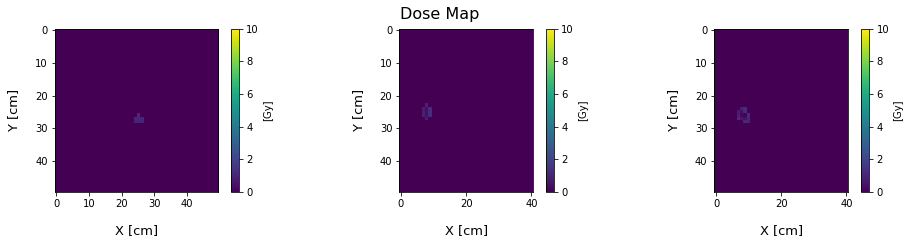

In [57]:
plot3DMap(pow(d_error_robust,0.5),"Dose Map","[Gy]",10)

In [58]:
print(pow(d_error_robust,0.5).sum()/(T[1]>0).sum())

0.8782800884997107
